In [23]:
# 基本的なパッケージ
import numpy as np # 線形代数
import pandas as pd # データの加工, CSVファイルのI/O (e.g. pd.read_csv)
import random as rd # 乱数の生成
import datetime # manipulating date formats
# 可視化用
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# 時系列解析用
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from fbprophet import Prophet

# 設定
import warnings
warnings.filterwarnings("ignore")

In [4]:
item=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/items.csv")
item_categories=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/item_categories.csv")
sales_train=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sales_train.csv")
shops=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/shops.csv")
test_csv=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/test.csv")
sample_submission=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sample_submission.csv")

In [5]:
# 日付カラムを正しくフォーマットする
sales_train.date=sales_train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# 確認
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [6]:
# 必要なメトリクスを月次レベルで集計

monthly_sales=sales_train.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## コードをブレイクダウンして理解していきます:
# 日付ブロック（月）とshop_id、item_idによる集計
#agg()の引数に、適用したい処理を表す文字列や呼び出し可能オブジェクトのリストを指定
# date,item_price,item_cnt(sales)の各カラムを選択
# どのカラムに対してどのような集約を行うかを示す辞書を用意
# 日付の最小値と最大値
# item_priceの平均値
# 売上高の合計

In [7]:
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

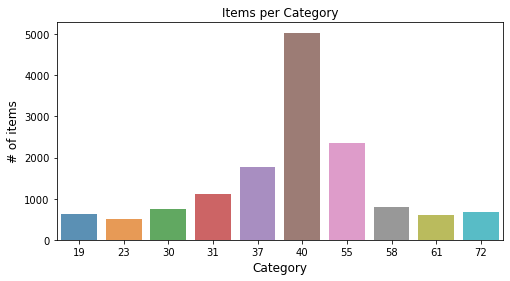

In [8]:
# カテゴリごとのアイテム数
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# plot
# alphaで透過率
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

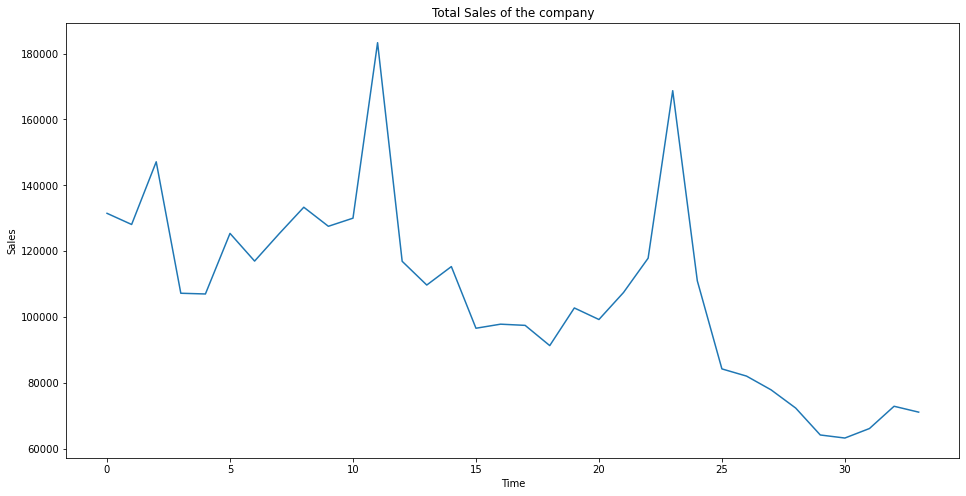

In [9]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

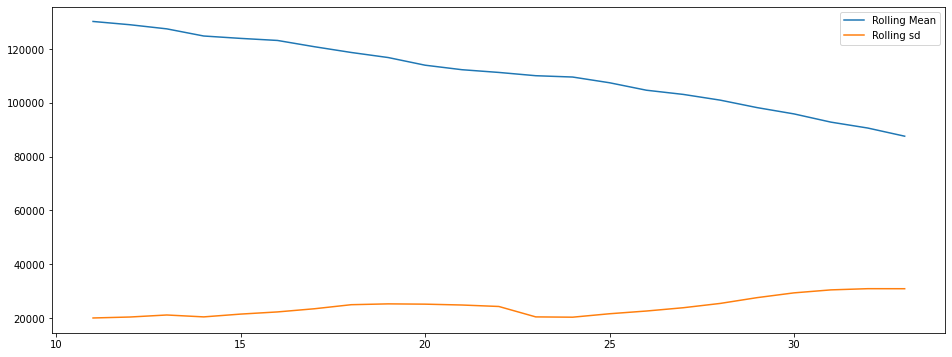

In [10]:
#(rolling)窓関数はフィルタをデザインする際などに使われるが、単純に移動平均線を算出（前後のデータの平均を算出）したりするのにも使える。
#window:Windowの幅を指定
#１年ごとの平均と誤差の推移
#例ではrolling(3)で上から順に3個ずつデータが選択されsum()で合計が算出される。
#s[0], s[1], s[2]の合計 → 返り値の[2]に格納
#s[1], s[2], s[3]の合計 → 返り値の[3]に格納
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

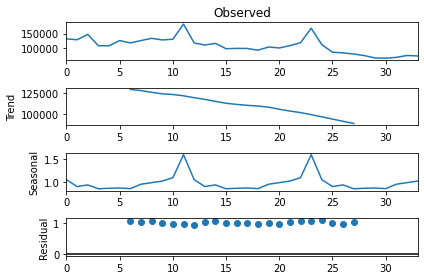

In [11]:
import statsmodels.api as sm
# 積算(model='multiplicative)
# 残差 (不規則変動 = 誤差変動 + 特異的変動) (residual)
#https://blog.amedama.jp/entry/sm-decompose-series
#https://data.gunosy.io/entry/statsmodel_trend
#freq には周期を入力します。
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

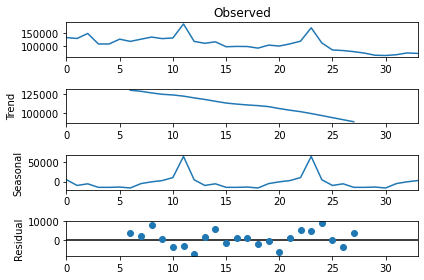

In [12]:
# 加算モデル
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [13]:
#Stationarity（定常性）とは、時系列の時間的不変性を意味します。すなわち、時系列の2つの点は、互いにどれだけ離れているかだけで関係しており、方向（前進／後退）によっては関係していません。
#時系列が定常の場合、モデル化が容易になります。統計的なモデリング手法は、時系列が定常であることを前提としたり、必要としたりします。
# 定常性の検定
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [14]:
# トレンドを取り除く
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

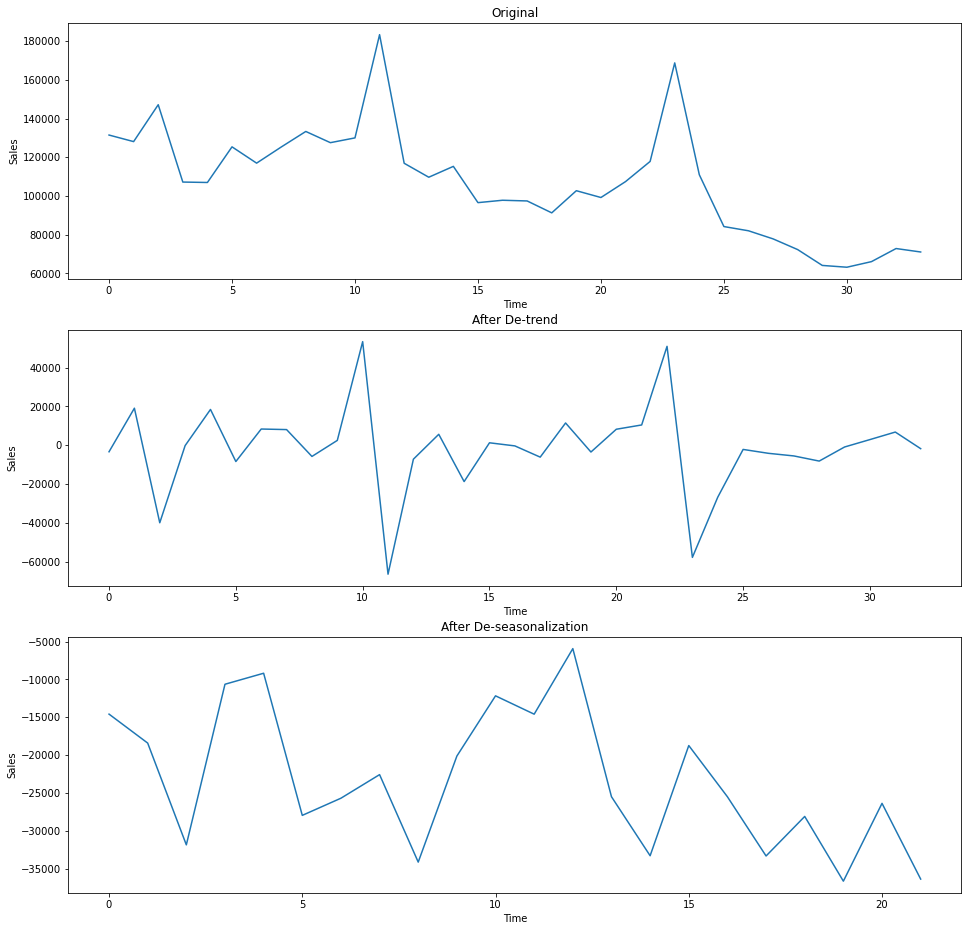

In [15]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # 季節性は12か月とおく
plt.plot(new_ts)
plt.plot()

In [16]:
# 季節性を除いた上で、改めて定常性の検定を行う
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [17]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

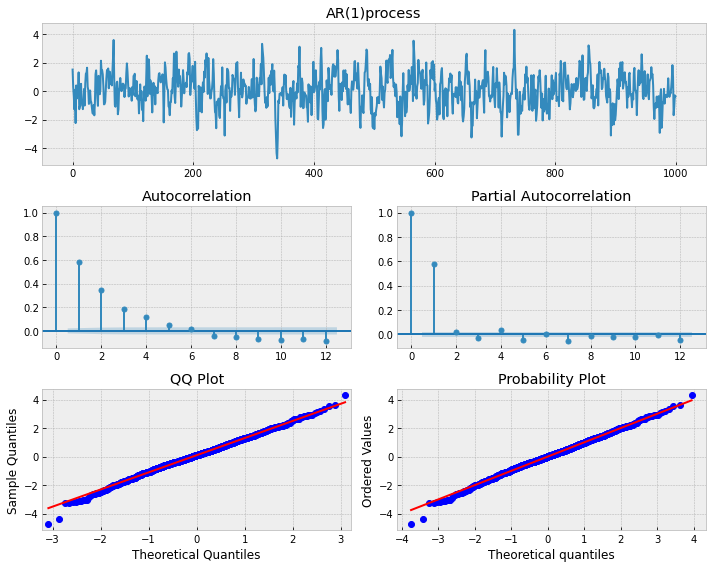

In [18]:
# AR(1)過程をalpha = 0.6でシミュレーション
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

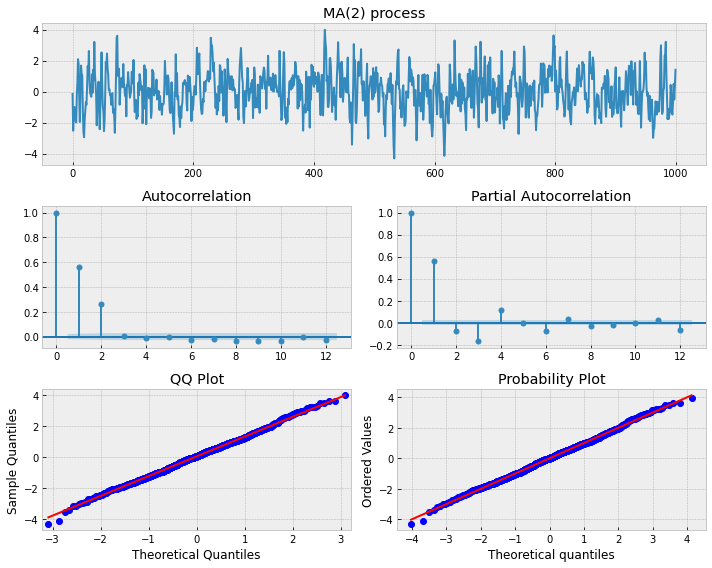

In [19]:
# MA(2)過程をbetas=0.6, 0.4でシミュレーションする
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

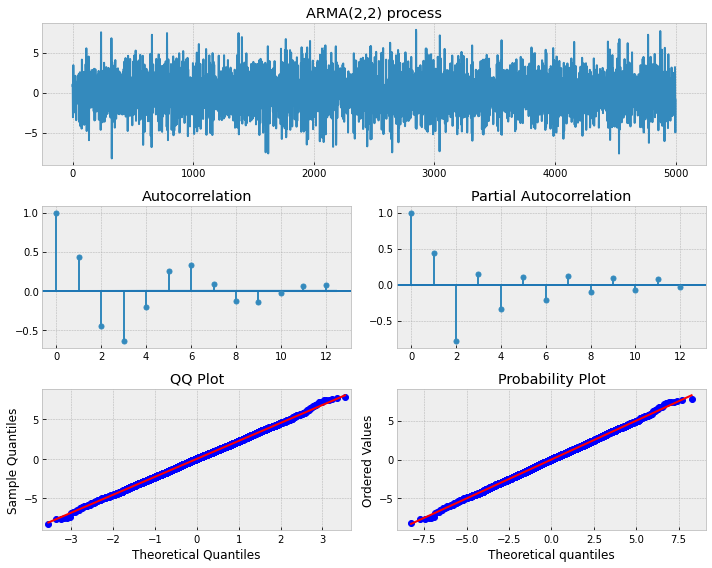

In [20]:
# ARMA(2, 2)モデルをalphas=[0.5,-0.25], betas=[0.5,-0.3]でシミュレーションする
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

In [21]:
#ARとMAのプロセスの順番を見つけるために、システム的なアプローチをしてみましょう.
# aicで最適な順番を選ぶ 
# 最小のaic値が勝つ
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15348.00252 | order: (4, 4)
